# design tradeoffs

this notebook explores how changing one parameter at a time affects heat loss.


In [6]:
import sys
import pathlib
import pandas as pd

repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from heat_loss_simulation import compute_specific_heat_loss
from visualizations import plot_component_breakdown

## 1. base design


In [7]:
base = {
    'sqft_roof': 1800,
    'sqft_walls': 1500,
    'roof_material_type': 'wood',
    'wall_material_type': 'wood',
    'ambient_temp_F': 30,
    'T_inside_F': 70,
    'duration_hours': 24,
    'insulation_r_value': 'R22-R33',
    'air_changes_per_hour': 0.5,
    'window_area_sqft': 400,
    'window_type': 'double',
    'electricity_cost_per_kWh': 0.12,
}
df_base = compute_specific_heat_loss(**base)
df_base

,sqft_roof,sqft_walls,roof_material_type,wall_material_type,ambient_temp_F,T_inside_F,duration_hours,insulation_r_value,air_changes_per_hour,window_area_sqft,...,Q_roof_kWh,Q_walls_kWh,Q_windows_kWh,Q_infiltration_kWh,Q_roof_pct,Q_walls_pct,Q_windows_pct,Q_infiltration_pct,total_cost,Q_total_kWh
0,1800,1500,wood,wood,30,70,24,R22-R33,0.5,400,...,17.639531,12.893316,55.494059,67.447578,11.493462,8.400951,36.158492,43.947096,18.416938,153.474483


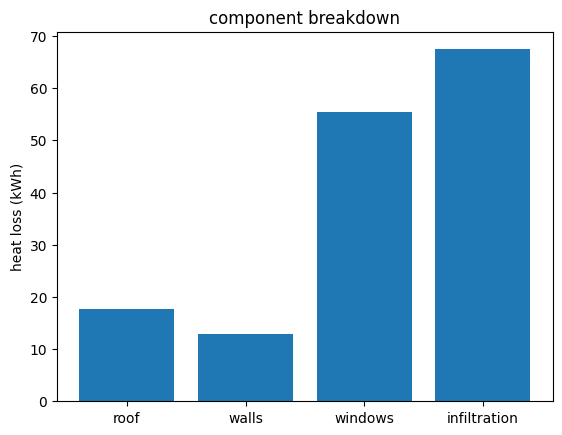

In [8]:
_ = plot_component_breakdown(df_base)

the bar chart shows how much each component contributes to total heat loss.


## 2. helper for one-at-a-time sweeps


In [9]:
def sweep_param(param_name, values, base):
    rows = []
    for v in values:
        params = dict(base)
        params[param_name] = v
        out = compute_specific_heat_loss(**params).copy()
        out[param_name] = v
        rows.append(out)
    return pd.concat(rows, ignore_index=True)

### 2a. vary insulation band


In [10]:
insulation_values = ['R13-R15', 'R16-R21', 'R22-R33', 'R34-R60']
df_insulation = sweep_param('insulation_r_value', insulation_values, base)
df_insulation[['insulation_r_value', 'Q_total_kWh', 'total_cost']].round(2)

,insulation_r_value,Q_total_kWh,total_cost
0,R13-R15,179.90,21.59
1,R16-R21,168.57,20.23
2,R22-R33,153.47,18.42
3,R34-R60,141.71,17.01


questions to consider:

- how much does `Q_total_kWh` drop when moving from one band to the next
- does the cost reduction per step stay constant


### 2b. vary window type


In [11]:
window_values = ['single', 'double', 'triple']
df_windows = sweep_param('window_type', window_values, base)
df_windows[['window_type', 'Q_total_kWh', 'total_cost']].round(2)

,window_type,Q_total_kWh,total_cost
0,single,210.95,25.31
1,double,153.47,18.42
2,triple,129.69,15.56


compare the impact of window upgrades to the insulation upgrades above.


### 2c. vary air changes per hour (ach)


In [12]:
ach_values = [0.3, 0.5, 0.7, 1.0]
df_ach = sweep_param('air_changes_per_hour', ach_values, base)
df_ach[['air_changes_per_hour', 'Q_total_kWh', 'total_cost']].round(2)

,air_changes_per_hour,Q_total_kWh,total_cost
0,0.3,126.50,15.18
1,0.5,153.47,18.42
2,0.7,180.45,21.65
3,1.0,220.92,26.51


for a project brief, pick one upgrade path and justify it using the tables above.
